# Import

In [1]:
import pandas as pd
import matplotlib.dates as mdates
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
import warnings
import itertools

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.stats.diagnostic import het_breuschpagan

# Ignore all warnings
warnings.filterwarnings("ignore")

In [2]:
# импортирую свой код
import arima_prophet_functions

Importing plotly failed. Interactive plots will not work.


# Purpose of this notebook

Этот ноутбук показывает обучение лучших ARIMA и Prophet моделей для данных загрузки ОНМК центров Санкт-Петербурга.

Данные представляют собой временной ряд месячной - загрузки центров с января 2017 по ноябрь 2024 года.

Оценка будет происходить суммарной загрузки центров в месяц, инными словами оценка будет проводиться для всех госпиталей сразу, не по отдельности.

# Data

Считываем данные и задаём основную колонку для анализа

In [3]:
!ls data

# MICE RF с госпиталями
data_path_MR = "data/data_summarized_by_month_filled_hosp_MR.tsv"

data_hosp_MR = pd.read_csv(data_path_MR, sep="\t")

F1.csv
F1.xlsx
data_summarized_by_month_filled.tsv
data_summarized_by_month_filled_hosp.tsv
data_summarized_by_month_filled_hosp_MR.tsv


In [4]:
main_column = 'Пролечены_с_ОНМК_Всего'

## Data Preparation

In [5]:
# MICE RF with hospitals
data_hosp_MR_used = data_hosp_MR.copy()

# Убираем ненужный госпиталь
data_hosp_MR_used = data_hosp_MR_used.loc[~data_hosp_MR_used.hosp.isin(["med1"])]

# Добавляем колонки с датой
data_hosp_MR_used.loc[:, 'Date'] = pd.to_datetime(data_hosp_MR_used[['year', 'month']].assign(Day=1))
data_hosp_MR_used.loc[:, 'Date_Graph'] = pd.to_datetime(data_hosp_MR_used[['year', 'month']].assign(Day=1)).dt.strftime('%Y-%m')

# Берем основные колонки
data_hosp_MR_used = data_hosp_MR_used.loc[:, [main_column, 'Date', 'Date_Graph', 'year', 'month']]

# Группируем и суммируем по госпиталям
data_hosp_MR_used = data_hosp_MR_used.groupby(['Date', 'Date_Graph', 'year', 'month']).sum().reset_index()

# Берем все время до ноября 2024
data_hosp_MR_used = data_hosp_MR_used.loc[data_hosp_MR_used.Date < pd.to_datetime("2024-10-31")]

# TS Checks

## Compare TimeSeries

In [6]:
# import matplotlib.pyplot as plt
# import numpy as np

# # Create the figure and axes
# fig, axes = plt.subplots(1, 1, figsize=(12, 12), sharex=True)
# axes = axes.flatten()

# # Define the datasets and titles
# datasets = [data_basic_used, data_hosp_used, data_hosp_MR_used]
# titles = ["All_Hospitals 2017-2024 (Basic)", 
#           "All_Hospitals 2017-2024 (Hospitals)", 
#           "All_Hospitals 2017-2024 (MR Hospitals)"]

# # Loop through axes and datasets
# for i, ax in enumerate(axes):
#     # Copy the data to avoid modifying the original
#     data_plot = datasets[i].copy()
    
#     # Plot the data
#     ax.plot(data_plot['Date_Graph'], data_plot[main_column], 
#             label="All_Hospitals", marker='o', color="gray")
    
#     # Set the title and labels
#     ax.set_title(titles[i], fontsize=14)
#     ax.set_ylabel("Hospital Load", fontsize=12)
    
#     # Set the xticks and labels
#     xticks = np.arange(len(data_plot['Date_Graph']))  # Index positions
#     skip_ticks = xticks[::2]  # Take every second tick
#     ax.set_xticks(skip_ticks)
#     ax.set_xticklabels(data_plot['Date_Graph'].iloc[skip_ticks], rotation=90)
    
#     # Add grid and legend
#     ax.grid(True, which='both', linestyle='--', linewidth=0.5)
#     ax.legend(fontsize=12)

# # Set shared x-axis label
# axes[-1].set_xlabel("Year-Month", fontsize=12)

# # Adjust layout and add a super title
# plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust for supertitle
# plt.suptitle("Hospital Load Over Time (2017-2024)", fontsize=16)

# # Show the plot
# plt.show()

Изучать наш временной ряд будем на отрезке 2017-2023 года. 2024 год будет отложен для тестирования модели.

In [7]:
data_used_model = data_hosp_MR_used.copy()

data_used_train = data_used_model.loc[data_used_model.Date < pd.to_datetime("2024-01-01")]
data_used_test = data_used_model.loc[data_used_model.Date >= pd.to_datetime("2024-01-01")]

## Decompose

In [8]:
data_ts = data_hosp_MR_used.loc[data_hosp_MR_used.year.isin([2017, 2018, 2019, 2020, 2021, 2022, 2023])][[main_column, 'Date']]
data_ts = pd.Series(data_ts[main_column])
data_ts.index = pd.date_range(start="2017-01-01", periods=84, freq="M")

Seasonal Strength: 0.306


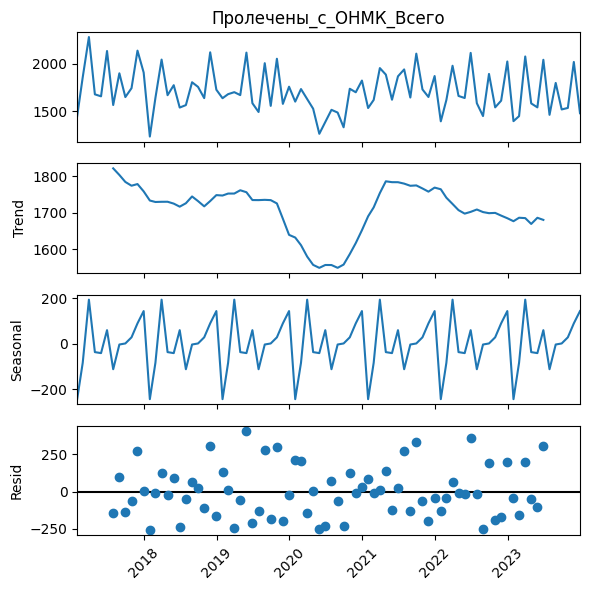

In [9]:
# Decompose the time series
decomposition = seasonal_decompose(data_ts, model='additive')
seasonal = decomposition.seasonal
residual = decomposition.resid

# Calculate variances
residual_variance = np.var(residual.dropna())
seasonal_variance = np.var(seasonal.dropna())

# Calculate Seasonal Strength
seasonal_strength = 1 - (residual_variance / (residual_variance + seasonal_variance))

print(f"Seasonal Strength: {seasonal_strength:.3f}")
fig = decomposition.plot()  # `decomposition.plot()` returns a Figure
fig.set_size_inches(6, 6)  # Optional: Adjust the figure size

# Rotate x-axis tick labels for each subplot
for ax in fig.axes:
    for label in ax.get_xticklabels():
        label.set_rotation(45)

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

## Dickey-Fuller test

### DF w/o differencing

In [10]:
from statsmodels.tsa.stattools import adfuller

In [11]:
data_plot = data_hosp_MR_used.copy()
data_plot.set_index('Date', inplace=True)
data_plot = data_plot.dropna().fillna(0)

# Perform the Dickey-Fuller test
result = adfuller(data_plot[main_column])

# Display results
print(f'*** {"All_Hospitals"} ***')
print("Dickey-Fuller Test Results:")
print(f"Test Statistic: {result[0]}")
print(f"p-value: {result[1]}")
print(f"Number of Lags Used: {result[2]}")
print(f"Number of Observations Used: {result[3]}")
print("Critical Values:")
for key, value in result[4].items():
    print(f"   {key}: {value}")

*** All_Hospitals ***
Dickey-Fuller Test Results:
Test Statistic: -3.036366478552415
p-value: 0.031634988394189344
Number of Lags Used: 9
Number of Observations Used: 84
Critical Values:
   1%: -3.510711795769895
   5%: -2.8966159448223734
   10%: -2.5854823866213152


Видим стационарность, но не слабую p=0.03, Попробуем продифференцировать ряд.

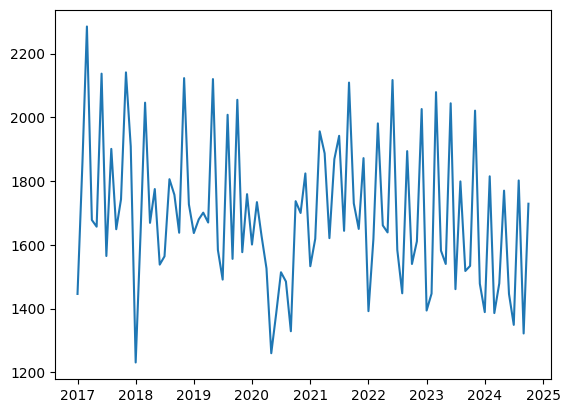

In [12]:
plt.plot(data_plot[main_column])

### DF test with differencing

In [13]:
data_plot = data_hosp_MR_used.copy()
data_plot.set_index('Date', inplace=True)
data_plot = data_plot.dropna().fillna(0)

# дифференцирование
series = data_plot[main_column].diff(1).dropna()

# Perform the Dickey-Fuller test
result = adfuller(series)

# Display results
print(f'*** {"All_Hospitals"} ***')
print("Dickey-Fuller Test Results:")
print(f"Test Statistic: {result[0]}")
print(f"p-value: {result[1]}")
print(f"Number of Lags Used: {result[2]}")
print(f"Number of Observations Used: {result[3]}")
print("Critical Values:")
for key, value in result[4].items():
    print(f"   {key}: {value}")

*** All_Hospitals ***
Dickey-Fuller Test Results:
Test Statistic: -4.928434258839517
p-value: 3.0692049629707045e-05
Number of Lags Used: 5
Number of Observations Used: 87
Critical Values:
   1%: -3.5078527246648834
   5%: -2.895382030636155
   10%: -2.584823877658872


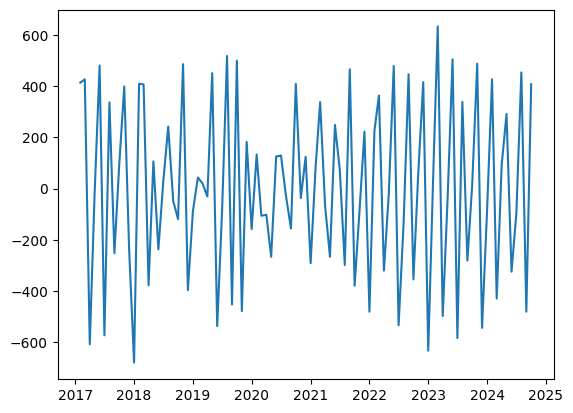

In [14]:
plt.plot(data_plot[main_column].diff(1).dropna())

Оп, уже стационарность побольше! И ряд сам "выравнивается" - нет линейных трендов, что хорошо для ARIMA моделей. Поэтому будем использовать дифференцированный ряд.

## PACF/ACF

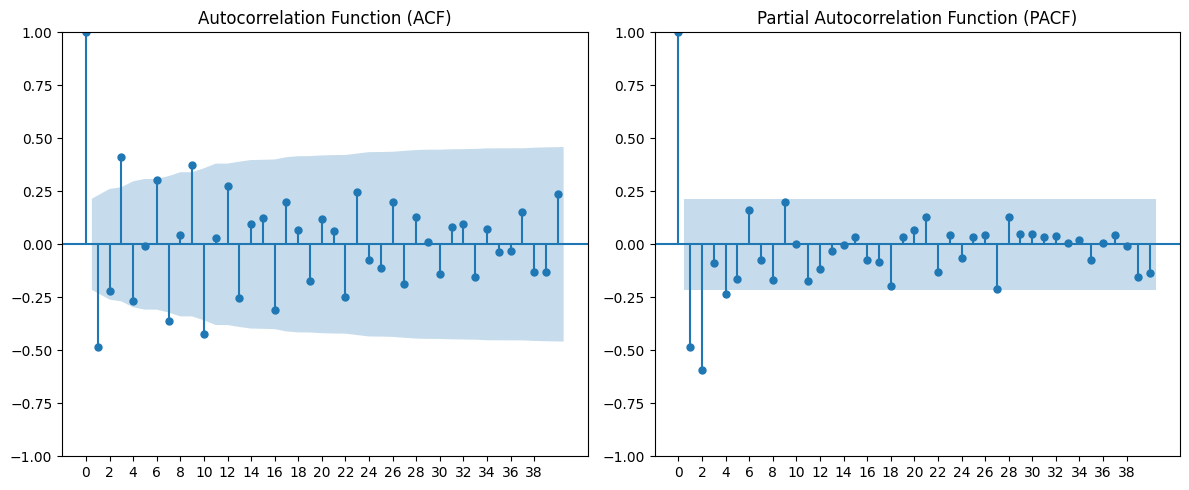

In [15]:
# Select the Load time series
load_series = pd.Series(data_used_train[main_column]).diff(1).dropna()

# Plot ACF and PACF
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# ACF plot
plot_acf(load_series, ax=axes[0], lags=40)  # Adjust lags as needed
axes[0].set_title('Autocorrelation Function (ACF)')
axes[0].set_xticks(range(0, 40, 2))

# PACF plot
plot_pacf(load_series, ax=axes[1], lags=40, method='ywm')  # 'ywm' is robust for small samples
axes[1].set_title('Partial Autocorrelation Function (PACF)')
axes[1].set_xticks(range(0, 40, 2))

plt.tight_layout()
plt.show()

Что тут видим:  
ACF - ключевых компонент (компонент, выходящих за синюю критическую зону) 3 штуки  
PACF - 2 компоненты, выходящих за зону  

## My Auto_Arima

Так как работа пакета "auto_arima" меня ну строила, я написал собственный грид-серч с использованием itertools.  

Ниже будет показан тестовый прогон моего кода:

### ARIMA

In [16]:
# Example usage
# Assuming `time_series_data` is your pd.Series object
results = arima_prophet_functions.grid_search_arima(
    data=data_used_train[main_column],
    min_p=0,
    max_p=5,
    min_q=0,
    max_q=5,
    d=1,
    min_P=0,
    max_P=0,
    min_Q=0,
    max_Q=0,
    min_D=0,
    max_D=0,
    seasonal_period=12,
    trends=["n"]
)

In [17]:
results.sort_values('AIC').head()

,p,q,d,P,Q,D,seasonal_period,trend,AIC
29,4,5,1,0,0,0,12,n,1045.354399
17,2,5,1,0,0,0,12,n,1047.165300
35,5,5,1,0,0,0,12,n,1047.412144
23,3,5,1,0,0,0,12,n,1047.771729
5,0,5,1,0,0,0,12,n,1054.054548


### SARIMA

In [18]:
# Example usage
# Assuming `time_series_data` is your pd.Series object
results = arima_prophet_functions.grid_search_arima(
    data=data_used_train[main_column],
    min_p=0,
    max_p=5,
    min_q=0,
    max_q=5,
    d=1,
    min_P=1,
    max_P=1,
    min_Q=1,
    max_Q=1,
    min_D=0,
    max_D=0,
    seasonal_period=12,
    trends=["n"]
)

In [19]:
results.sort_values('AIC').head()

,p,q,d,P,Q,D,seasonal_period,trend,AIC
29,4,5,1,1,1,0,12,n,883.948428
17,2,5,1,1,1,0,12,n,884.057333
23,3,5,1,1,1,0,12,n,886.649834
35,5,5,1,1,1,0,12,n,887.223640
5,0,5,1,1,1,0,12,n,889.524956


<Axes: xlabel='q', ylabel='AIC'>

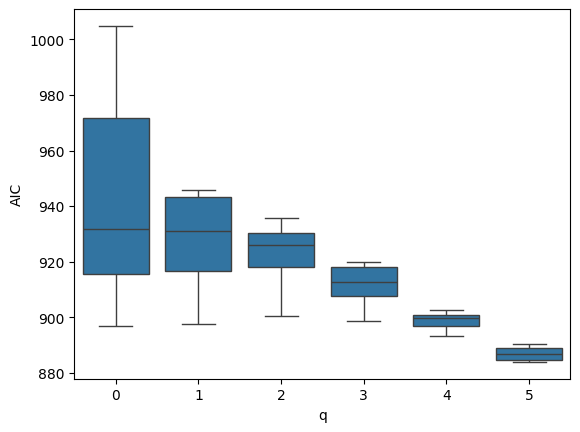

In [20]:
sns.boxplot(data=results, y="AIC", x="q")

# ARIMA models

Модуль обучения различных ARIMA моделей и поиска лучшей модели

## ARIMA(1, 1, 1)

Базовая АРИМА для сравнения

In [21]:
data_used_model = data_hosp_MR_used.copy()

train_month=84 #2017-2023

data_used_train = data_used_model.iloc[:train_month]
data_used_test = data_used_model.iloc[train_month:]

In [22]:
model = arima_prophet_functions.train_arima_model(data_used_model[main_column], order=(1, 1, 1), train_month=train_month, trend='n')
data_check_metrics = arima_prophet_functions.make_metrics_dataframe(model, data_used_train, data_used_test, main_column)
print(model.summary())

metrics_df = arima_prophet_functions.calculate_model_metrics(model, data_check_metrics, main_column)
metrics_df

                                 SARIMAX Results                                  
Dep. Variable:     Пролечены_с_ОНМК_Всего   No. Observations:                   84
Model:                   SARIMAX(1, 1, 1)   Log Likelihood                -554.497
Date:                    Thu, 30 Jan 2025   AIC                           1114.995
Time:                            20:07:37   BIC                           1122.178
Sample:                                 0   HQIC                          1117.877
                                     - 84                                         
Covariance Type:                      opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2334      0.131     -1.779      0.075      -0.491       0.024
ma.L1         -0.8828      0.066    -13.475      0.000      -1.011      -0.754
sigma2      5.131e+0

Dataset,TRAIN,TEST
MAE,214.137296,217.734950
MSE,82432.935135,59746.172263
RMSE,287.111364,244.430301
MAPE (%),12.819832,15.103578
AIC,1114.994535,NaN




Ljung-Box Test
      lb_stat  lb_pvalue
10  12.362577   0.261523


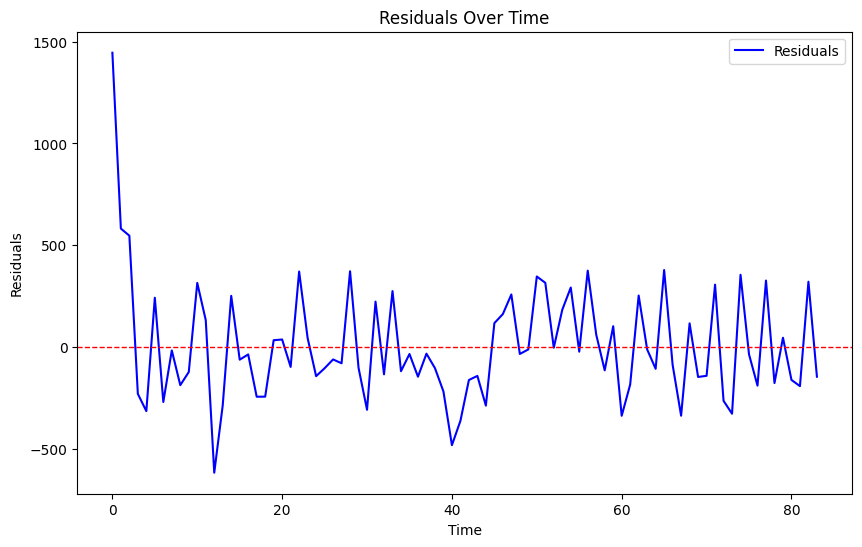

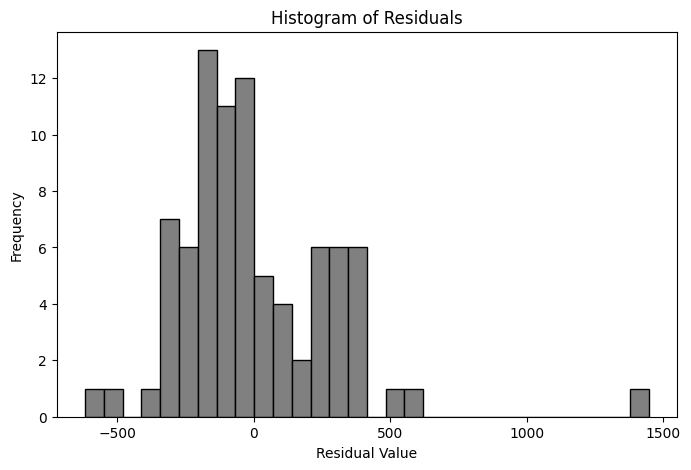

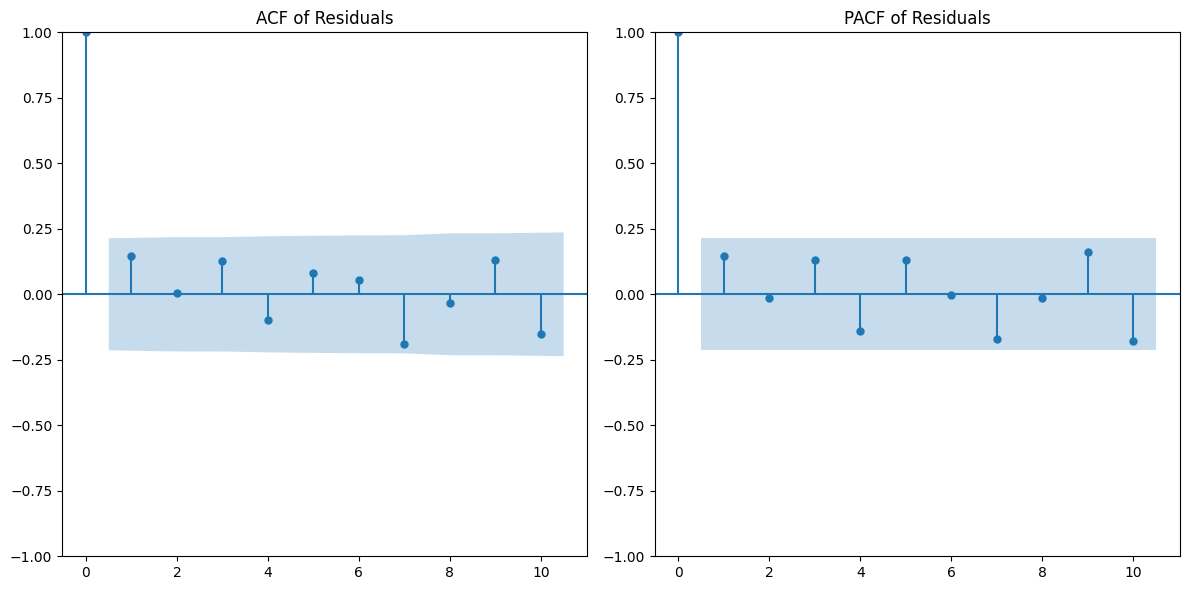

In [23]:
arima_prophet_functions.model_performance(data_check_metrics, main_column)

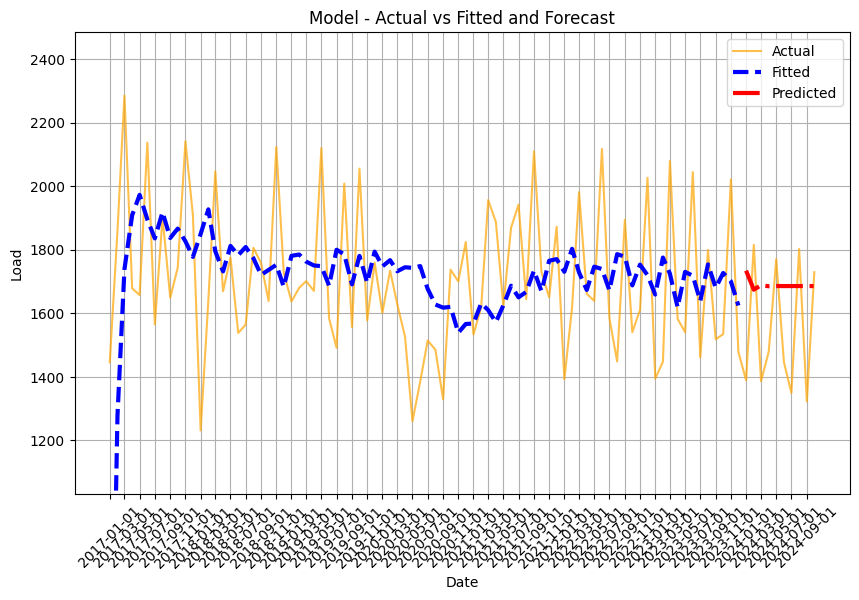

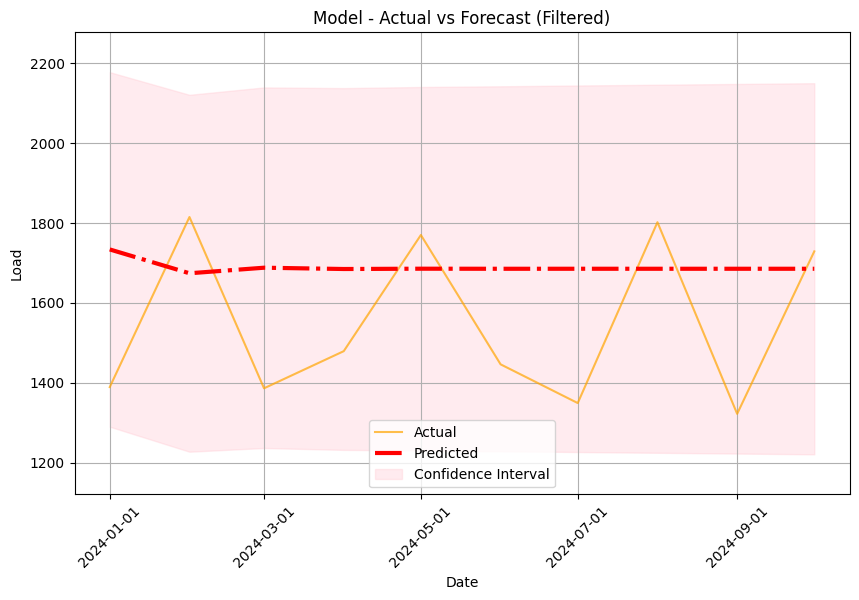

In [24]:
arima_prophet_functions.plot_model_results(data_check_metrics, main_column,
                   date_column='Date_Graph', 
                         prediction_column=f"{main_column}_Prediction", fitted_column=f"{main_column}_Fitted",
                         ci_low_column=f"{main_column}_Prediction_CI_low", ci_upp_column=f"{main_column}_Prediction_CI_upp", 
                         cutoff_date="12-30-2023", vertical_line_date=None, 
                         vertical_line_ymin=None, vertical_line_ymax=None)

### Rolling Prediction

In [25]:
train_month_start = 84
train_month_end = 94
final_data_check_metrics, model_first = arima_prophet_functions.rolling_prediction_function(data_used_model, main_column, (1,1,1), 
                                                       train_month_start=train_month_start, 
                                                       train_month_end=train_month_end)

In [26]:
arima_prophet_functions.calculate_model_metrics(model_first, final_data_check_metrics, main_column)

*** TRAIN ***
MAE: 214.14
MSE: 82432.94
RMSE: 287.11
MAPE: 12.82%
AIC: 1114.9945345742562

*** TEST ***
MAE: 199.50
MSE: 45576.68
RMSE: 213.49
MAPE: 13.53%


Dataset,TRAIN,TEST
MAE,214.137296,199.501572
MSE,82432.935135,45576.676463
RMSE,287.111364,213.486947
MAPE (%),12.819832,13.531049
AIC,1114.994535,NaN


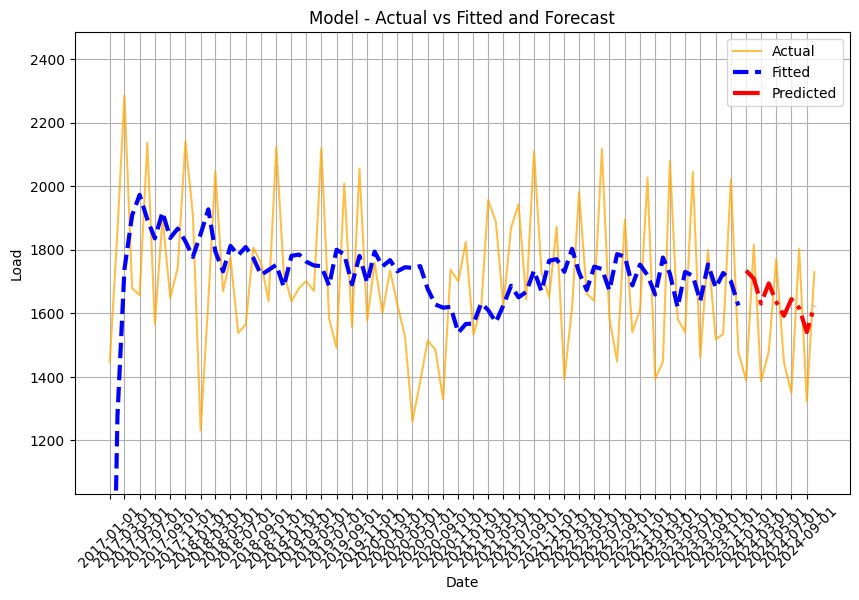

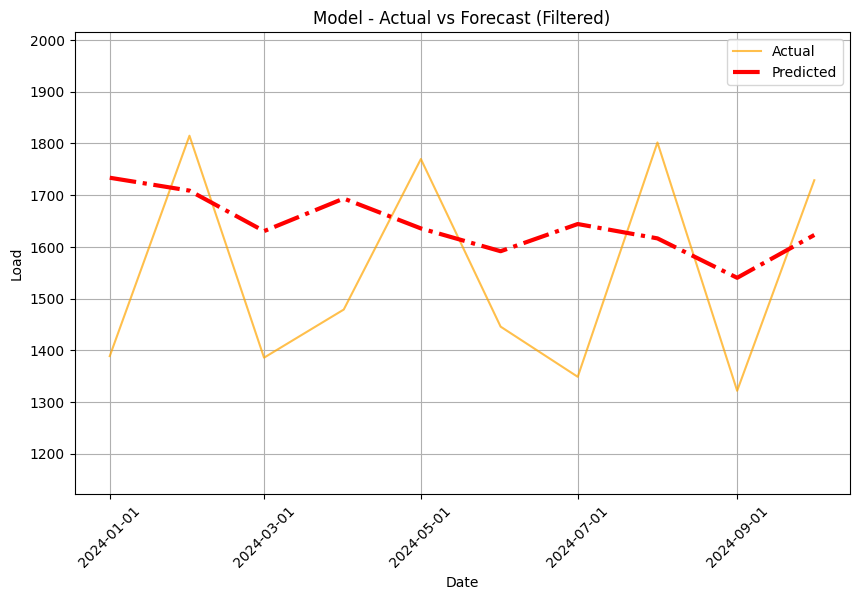

In [27]:
arima_prophet_functions.plot_model_results(final_data_check_metrics, main_column,
                   date_column='Date_Graph', 
                         prediction_column=f"{main_column}_Prediction", fitted_column=f"{main_column}_Fitted",
                         cutoff_date="12-30-2023", vertical_line_date=None, 
                         vertical_line_ymin=None, vertical_line_ymax=None)

## ARIMA(2, 1, 3)

In [28]:
data_used_model = data_hosp_MR_used.copy()

train_month=84 #2017-2023

data_used_train = data_used_model.iloc[:train_month]
data_used_test = data_used_model.iloc[train_month:]

In [29]:
model = arima_prophet_functions.train_arima_model(data_used_model[main_column], order=(2, 1, 3), train_month=train_month, trend='n')
data_check_metrics = arima_prophet_functions.make_metrics_dataframe(model, data_used_train, data_used_test, main_column)
print(model.summary())

metrics_df = arima_prophet_functions.calculate_model_metrics(model, data_check_metrics, main_column)
metrics_df

                                 SARIMAX Results                                  
Dep. Variable:     Пролечены_с_ОНМК_Всего   No. Observations:                   84
Model:                   SARIMAX(2, 1, 3)   Log Likelihood                -529.077
Date:                    Thu, 30 Jan 2025   AIC                           1070.153
Time:                            20:07:38   BIC                           1084.370
Sample:                                 0   HQIC                          1075.849
                                     - 84                                         
Covariance Type:                      opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.1369      0.017    -65.637      0.000      -1.171      -1.103
ar.L2         -0.9950      0.019    -51.576      0.000      -1.033      -0.957
ma.L1          0.320

Dataset,TRAIN,TEST
MAE,203.510432,147.257832
MSE,98045.286626,32045.747262
RMSE,313.121840,179.013260
MAPE (%),12.129705,10.000349
AIC,1070.153429,NaN




Ljung-Box Test
      lb_stat  lb_pvalue
10  20.968363   0.021315


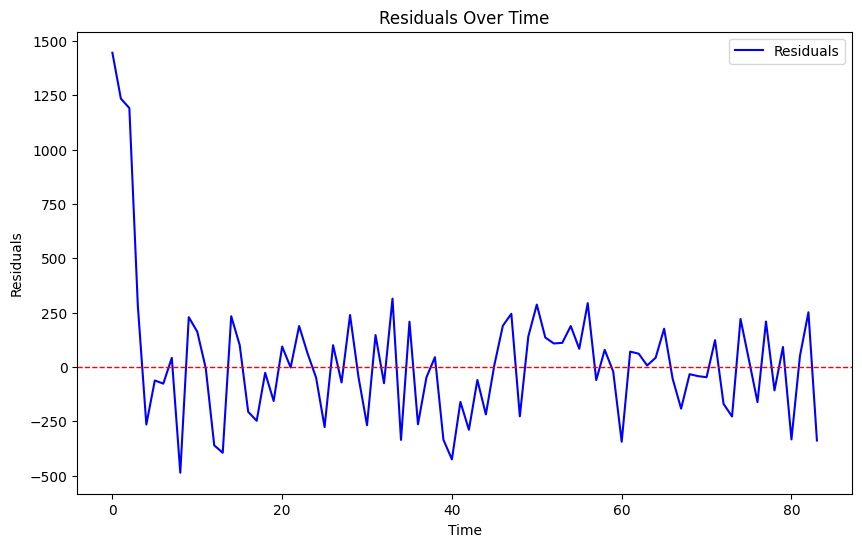

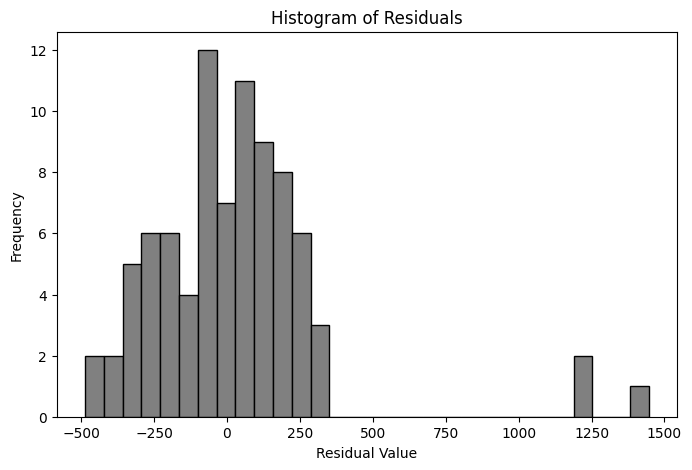

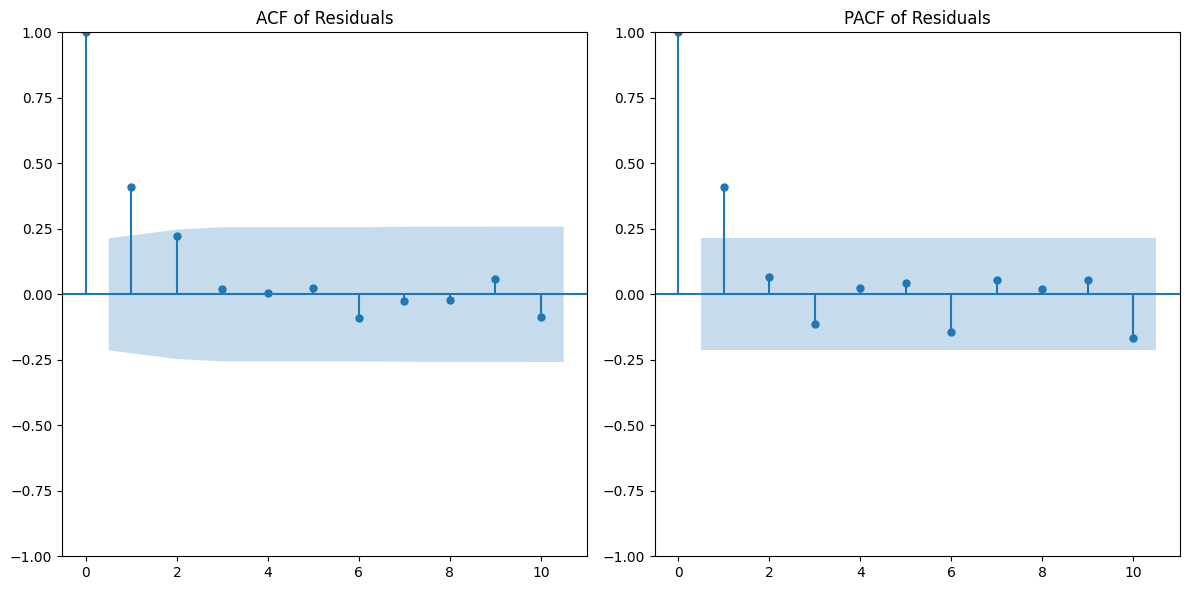

In [30]:
arima_prophet_functions.model_performance(data_check_metrics, main_column)

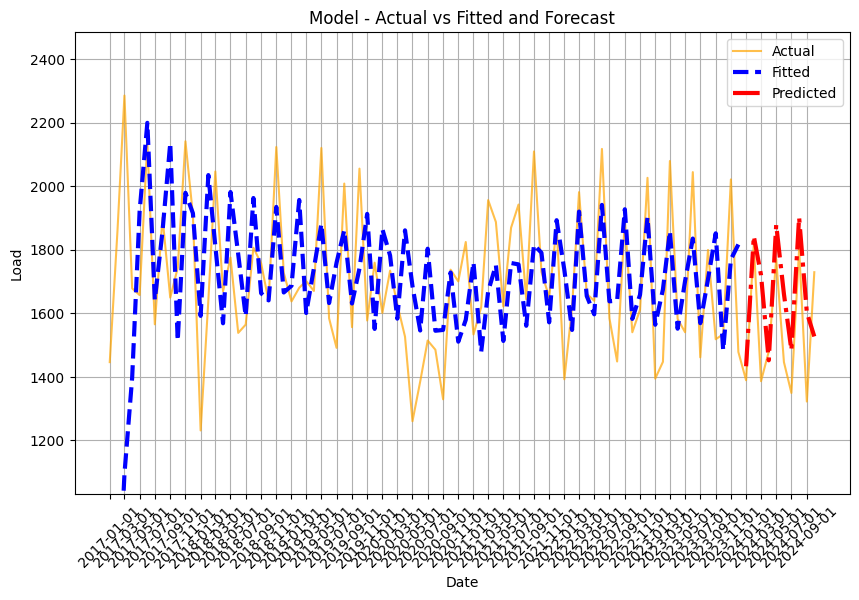

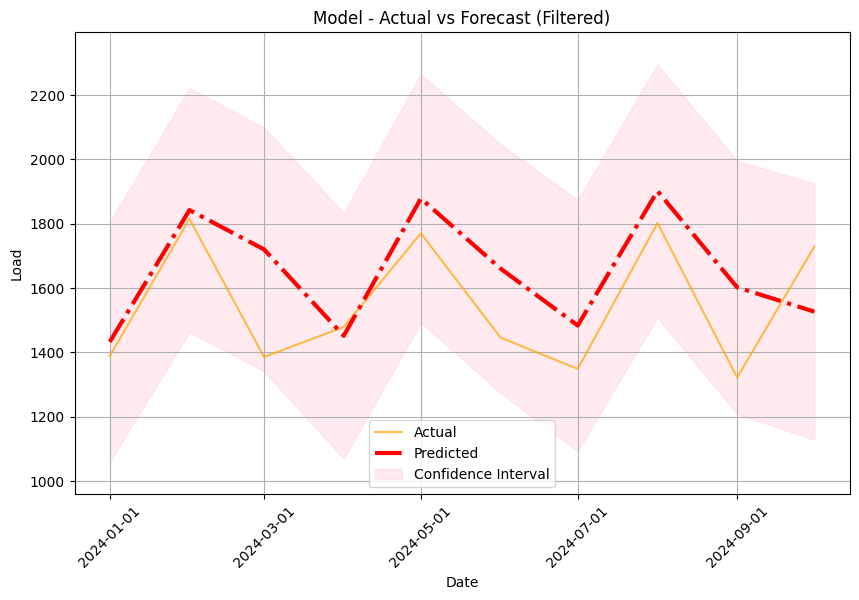

In [31]:
arima_prophet_functions.plot_model_results(data_check_metrics, main_column,
                   date_column='Date_Graph', 
                         prediction_column=f"{main_column}_Prediction", fitted_column=f"{main_column}_Fitted",
                         ci_low_column=f"{main_column}_Prediction_CI_low", ci_upp_column=f"{main_column}_Prediction_CI_upp", 
                         cutoff_date="12-30-2023", vertical_line_date=None, 
                         vertical_line_ymin=None, vertical_line_ymax=None)

### Rolling Prediction

In [32]:
final_data_check_metrics, model_first = arima_prophet_functions.rolling_prediction_function(data_used_model, main_column, (2,1,3), 
                                                       train_month_start=train_month_start, 
                                                       train_month_end=train_month_end)

In [33]:
arima_prophet_functions.calculate_model_metrics(model_first, final_data_check_metrics, main_column)

*** TRAIN ***
MAE: 203.51
MSE: 98045.29
RMSE: 313.12
MAPE: 12.13%
AIC: 1070.153429480983

*** TEST ***
MAE: 121.60
MSE: 24424.27
RMSE: 156.28
MAPE: 8.16%


Dataset,TRAIN,TEST
MAE,203.510432,121.601240
MSE,98045.286626,24424.271559
RMSE,313.121840,156.282666
MAPE (%),12.129705,8.158376
AIC,1070.153429,NaN


In [34]:
final_data_check_metrics

,Date,Date_Graph,Пролечены_с_ОНМК_Всего,Пролечены_с_ОНМК_Всего_Fitted,Пролечены_с_ОНМК_Всего_Prediction,Пролечены_с_ОНМК_Всего_Prediction_CI_low,Пролечены_с_ОНМК_Всего_Prediction_CI_upp
0,2017-01-01,2017-01,1446.0,0.000000,None,None,None
1,2017-02-01,2017-02,1859.0,624.025294,None,None,None
2,2017-03-01,2017-03,2285.0,1093.769856,None,None,None
3,2017-04-01,2017-04,1678.0,1397.157963,None,None,None
4,2017-05-01,2017-05,1657.0,1921.589855,None,None,None
...,...,...,...,...,...,...,...
89,2024-06-01,2024-06,1446.0,NaN,1551.242293,1162.663339,1939.821247
90,2024-07-01,2024-07,1349.0,NaN,1459.59544,1073.438359,1845.752521
91,2024-08-01,2024-08,1802.0,NaN,1830.500051,1443.776983,2217.22312
92,2024-09-01,2024-09,1322.0,NaN,1458.503434,1094.459409,1822.54746


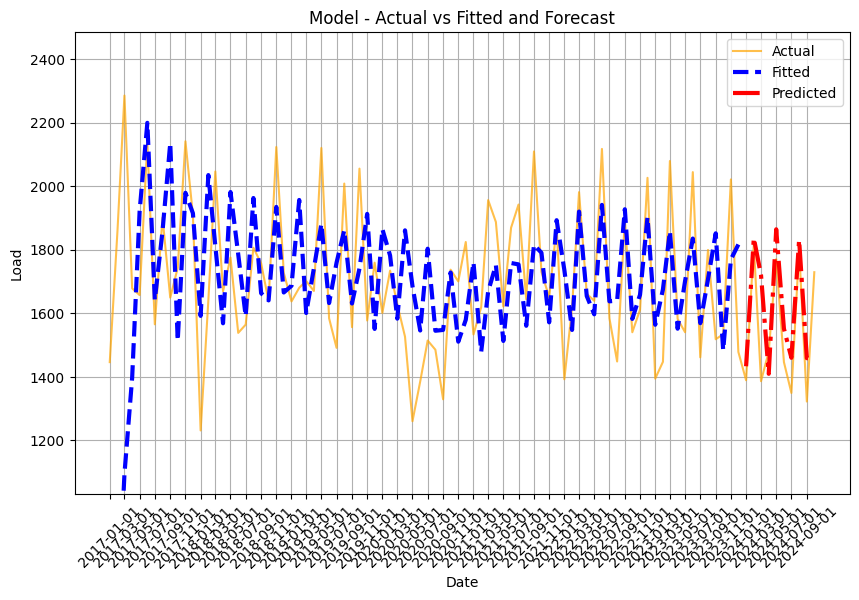

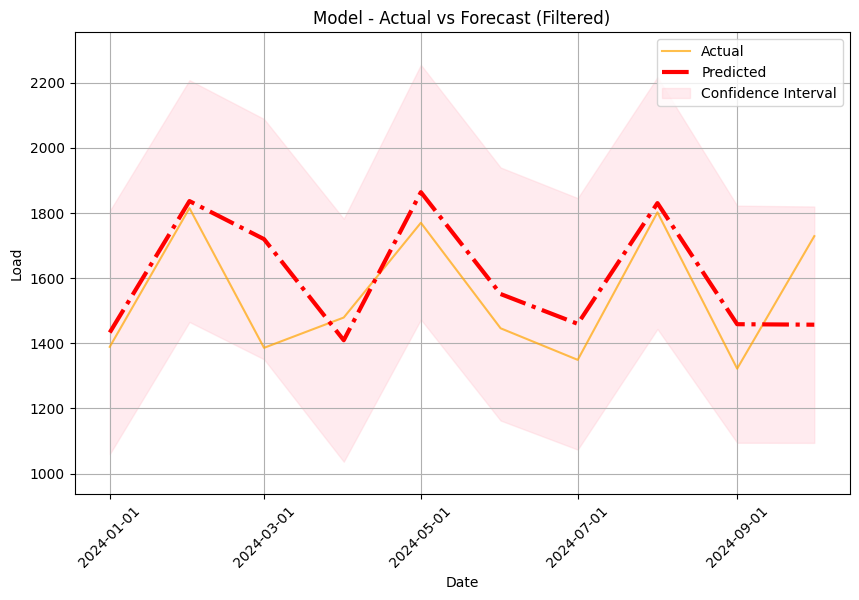

In [35]:
arima_prophet_functions.plot_model_results(final_data_check_metrics, main_column,
                   date_column='Date_Graph', 
                         prediction_column=f"{main_column}_Prediction", fitted_column=f"{main_column}_Fitted",
                         cutoff_date="12-30-2023",
                         ci_low_column=f"{main_column}_Prediction_CI_low", ci_upp_column=f"{main_column}_Prediction_CI_upp",
                                           vertical_line_date=None, 
                         vertical_line_ymin=None, vertical_line_ymax=None)

## SARIMA(2, 1, 3)(1, 0, 1, 12)

In [36]:
data_used_model = data_hosp_MR_used.copy()

train_month=84 #2017-2023

data_used_train = data_used_model.iloc[:train_month]
data_used_test = data_used_model.iloc[train_month:]

In [37]:
model = arima_prophet_functions.train_arima_model(data_used_model[main_column], order=(2, 1, 3), train_month=train_month, trend='n',
                         seasonal_order=(1, 0, 1, 12))
data_check_metrics = arima_prophet_functions.make_metrics_dataframe(model, data_used_train, data_used_test, main_column)
print(model.summary())

metrics_df = arima_prophet_functions.calculate_model_metrics(model, data_check_metrics, main_column)
metrics_df

                                      SARIMAX Results                                       
Dep. Variable:               Пролечены_с_ОНМК_Всего   No. Observations:                   84
Model:             SARIMAX(2, 1, 3)x(1, 0, [1], 12)   Log Likelihood                -445.405
Date:                              Thu, 30 Jan 2025   AIC                            906.810
Time:                                      20:07:40   BIC                            924.447
Sample:                                           0   HQIC                           913.789
                                               - 84                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.1596      0.016    -73.907      0.000      -1.190      -1.129
ar.L2         -1.02

Dataset,TRAIN,TEST
MAE,217.096661,112.856308
MSE,110861.391485,16697.321712
RMSE,332.958543,129.218117
MAPE (%),12.832502,7.362880
AIC,906.809506,NaN


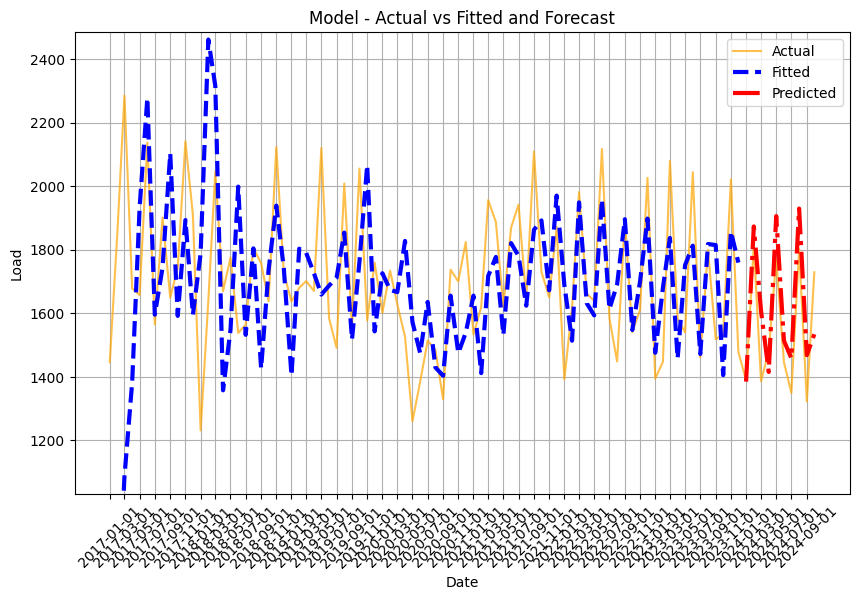

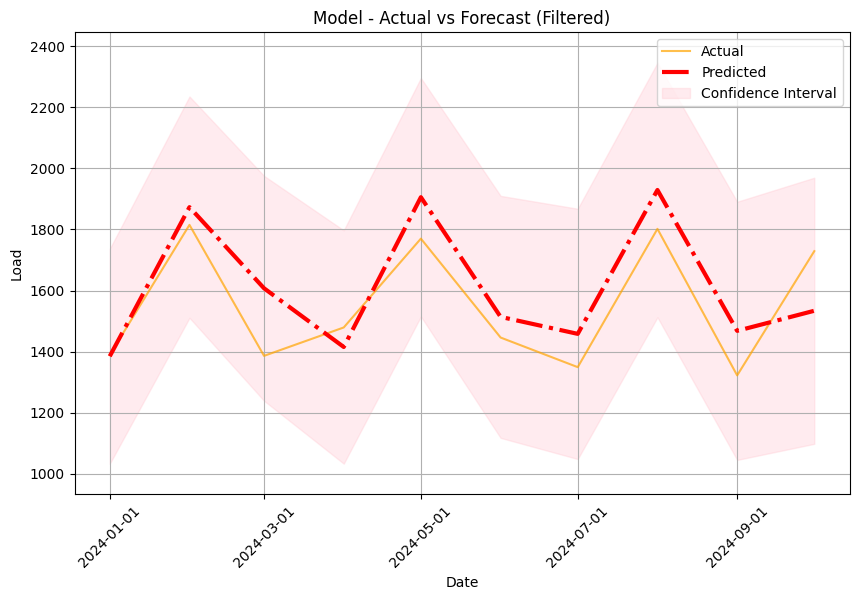

In [38]:
arima_prophet_functions.plot_model_results(data_check_metrics, main_column,
                   date_column='Date_Graph', 
                         prediction_column=f"{main_column}_Prediction", fitted_column=f"{main_column}_Fitted",
                         ci_low_column=f"{main_column}_Prediction_CI_low", ci_upp_column=f"{main_column}_Prediction_CI_upp", 
                         cutoff_date="12-30-2023", vertical_line_date=None, 
                         vertical_line_ymin=None, vertical_line_ymax=None)



Ljung-Box Test
      lb_stat  lb_pvalue
10  18.975142    0.04058


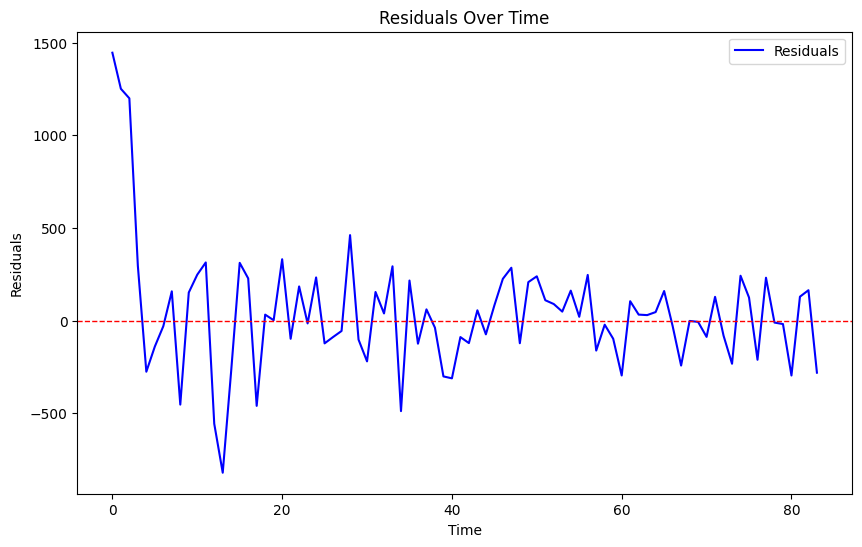

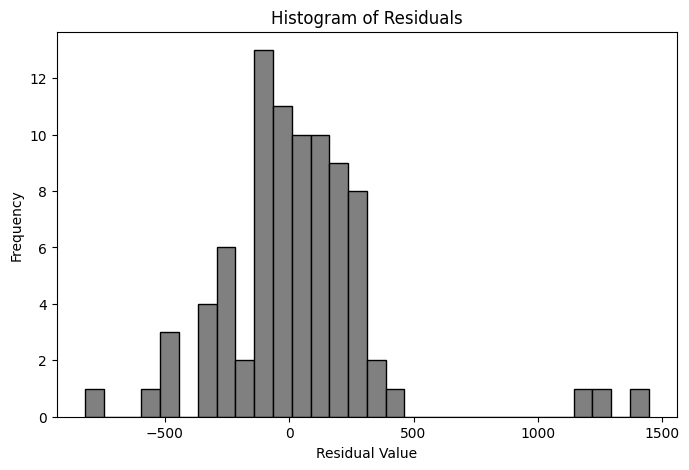

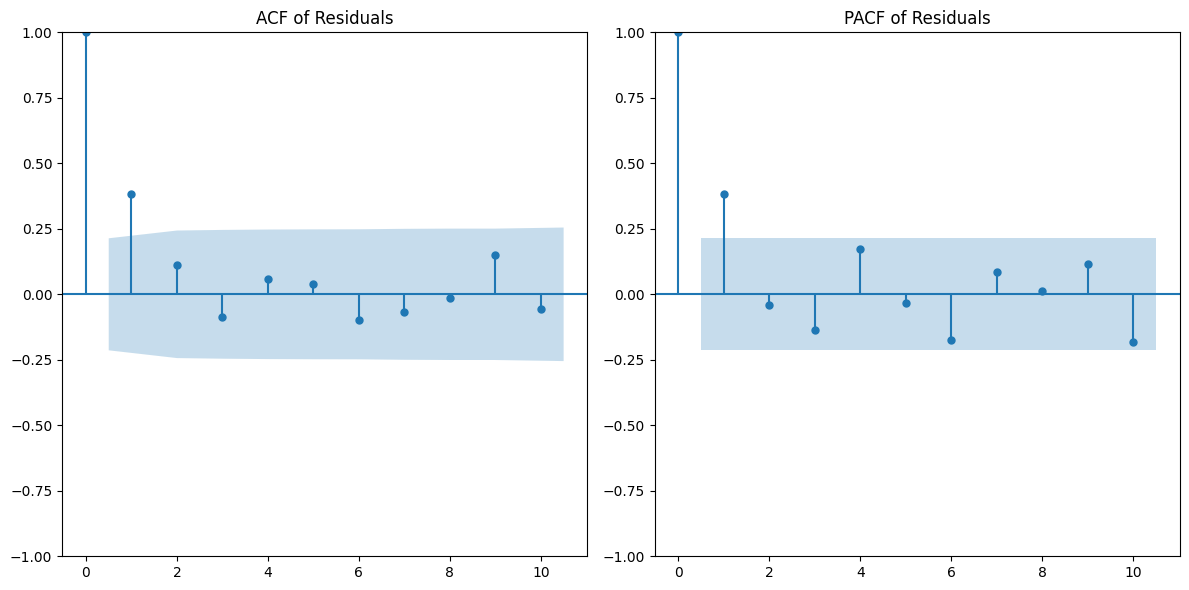

In [39]:
arima_prophet_functions.model_performance(data_check_metrics, main_column)

### Rolling Prediction

In [40]:
final_data_check_metrics, model_first = arima_prophet_functions.rolling_prediction_function(data_used_model, main_column, (2,1,3), seasonal_order=(1, 0, 1, 12), train_month_start=84, train_month_end=94)

In [41]:
arima_prophet_functions.calculate_model_metrics(model_first, final_data_check_metrics, main_column)

*** TRAIN ***
MAE: 217.10
MSE: 110861.39
RMSE: 332.96
MAPE: 12.83%
AIC: 906.8095059859434

*** TEST ***
MAE: 108.89
MSE: 17436.32
RMSE: 132.05
MAPE: 7.02%


Dataset,TRAIN,TEST
MAE,217.096661,108.888046
MSE,110861.391485,17436.315568
RMSE,332.958543,132.046642
MAPE (%),12.832502,7.019480
AIC,906.809506,NaN


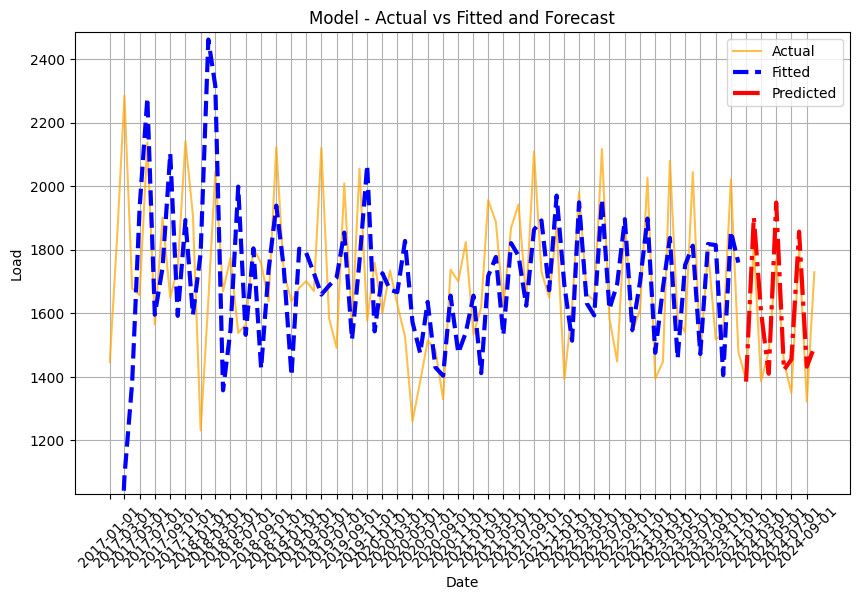

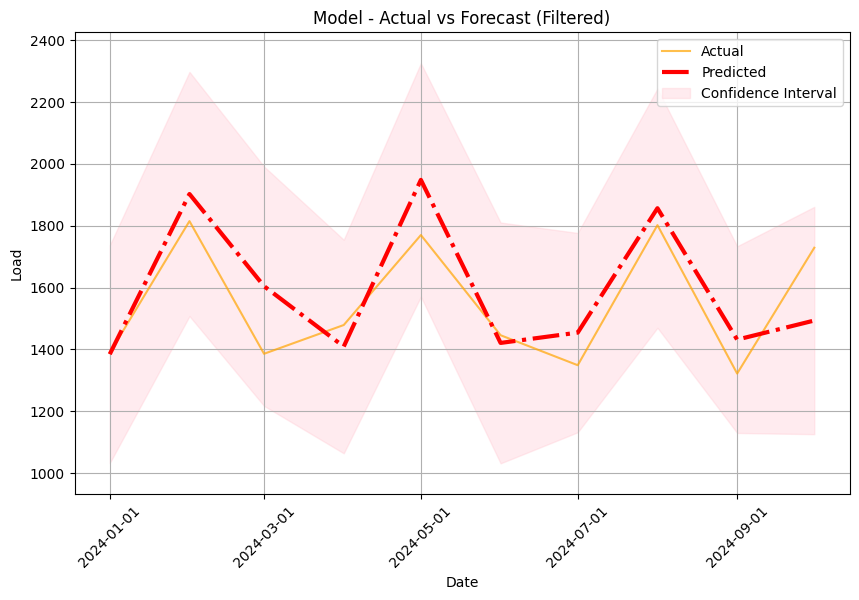

In [42]:
arima_prophet_functions.plot_model_results(final_data_check_metrics, main_column,
                   date_column='Date_Graph', 
                         prediction_column=f"{main_column}_Prediction", fitted_column=f"{main_column}_Fitted",
                         cutoff_date="12-30-2023",
                         ci_low_column=f"{main_column}_Prediction_CI_low", ci_upp_column=f"{main_column}_Prediction_CI_upp",
                                           vertical_line_date=None, 
                         vertical_line_ymin=None, vertical_line_ymax=None)

## SARIMAX (with exogeneous params)(2, 1, 3)(1, 0, 1, 12)

In [43]:
data_used_model['COVID'] = data_used_model['year'] == 2020
data_used_model['COVID'] = data_used_model['COVID'].astype(int) 

In [44]:
train_month=84 #2017-2023

data_used_train = data_used_model.iloc[:train_month]
data_used_test = data_used_model.iloc[train_month:]

### Train Best Model

In [45]:
model = arima_prophet_functions.train_arima_model(data_used_model[main_column], order=(2, 1, 3), trend="n", seasonal_order=(1, 0, 1, 12),
                                     exog=data_used_model['COVID'], train_month=84)
data_check_metrics = arima_prophet_functions.make_metrics_dataframe(model, data_used_train, data_used_test, main_column, exog_test=np.array(data_used_test['COVID']))
print(model.summary())

metrics_df = arima_prophet_functions.calculate_model_metrics(model, data_check_metrics, main_column)
metrics_df

                                      SARIMAX Results                                       
Dep. Variable:               Пролечены_с_ОНМК_Всего   No. Observations:                   84
Model:             SARIMAX(2, 1, 3)x(1, 0, [1], 12)   Log Likelihood                -445.533
Date:                              Thu, 30 Jan 2025   AIC                            909.066
Time:                                      20:07:43   BIC                            928.908
Sample:                                           0   HQIC                           916.918
                                               - 84                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1            55.4004    110.798      0.500      0.617    -161.759     272.560
ar.L1         -1.16

Dataset,TRAIN,TEST
MAE,218.589756,118.636750
MSE,111355.647097,17788.328890
RMSE,333.699936,133.372894
MAPE (%),12.925759,7.627024
AIC,909.066205,NaN


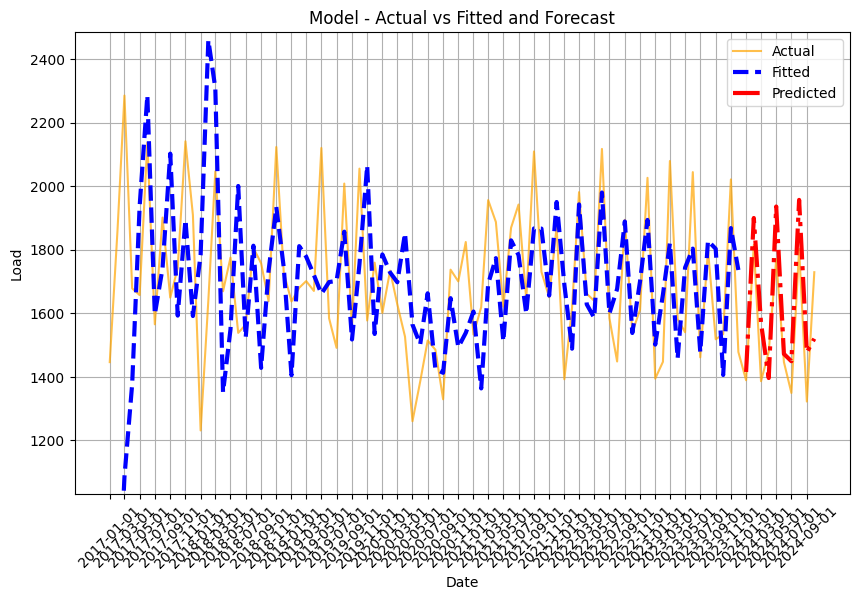

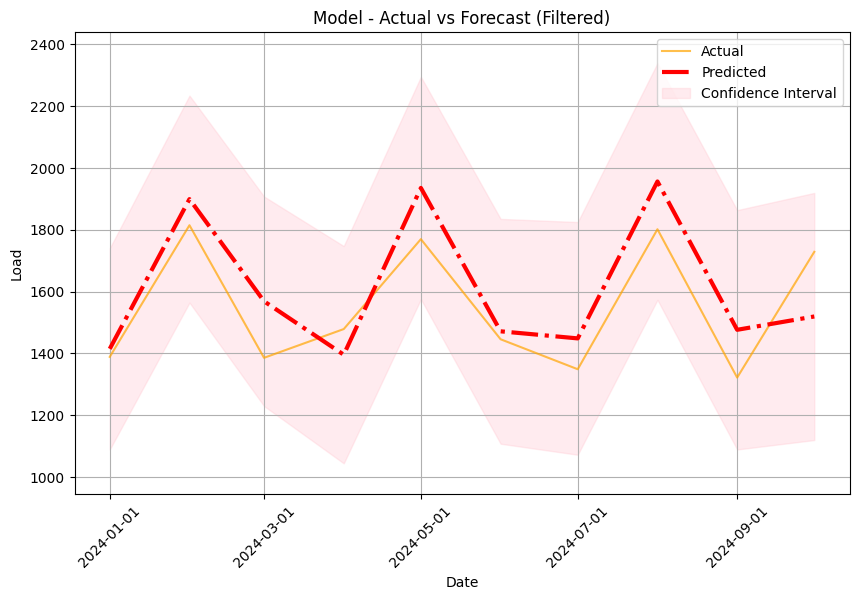

In [46]:
arima_prophet_functions.plot_model_results(data_check_metrics, main_column,
                   date_column='Date_Graph', 
                         prediction_column=f"{main_column}_Prediction", fitted_column=f"{main_column}_Fitted",
                         ci_low_column=f"{main_column}_Prediction_CI_low", ci_upp_column=f"{main_column}_Prediction_CI_upp", 
                         cutoff_date="12-30-2023", vertical_line_date=None, 
                         vertical_line_ymin=None, vertical_line_ymax=None)



Ljung-Box Test
      lb_stat  lb_pvalue
10  19.137908   0.038546


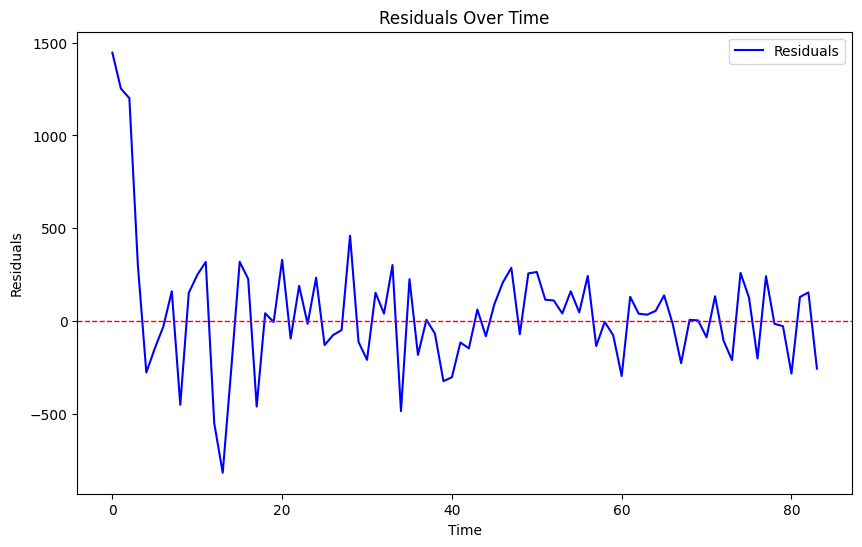

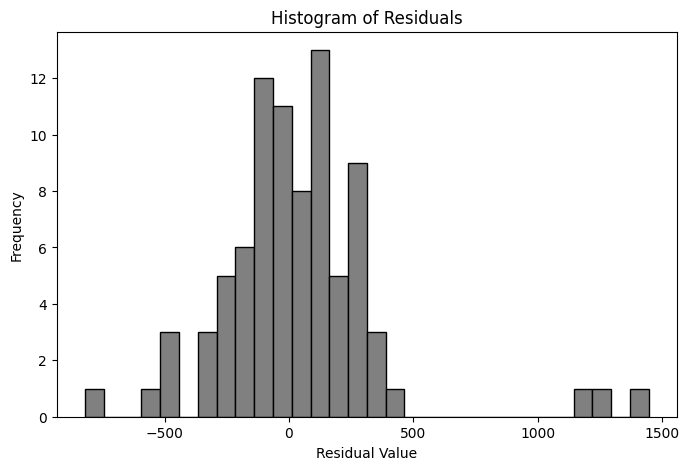

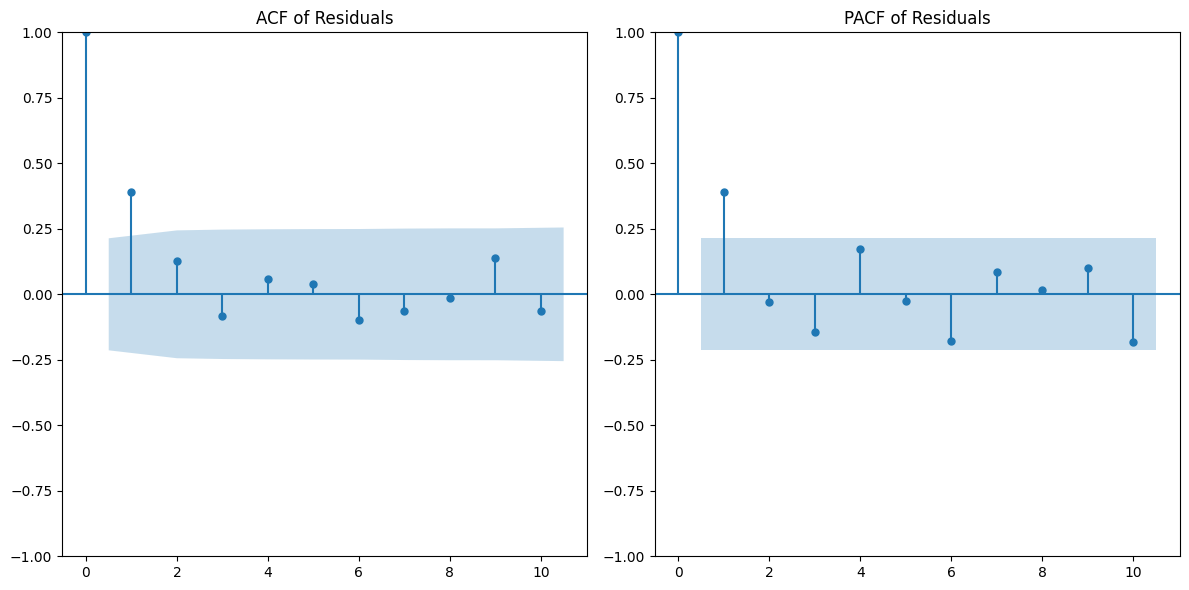

In [47]:
arima_prophet_functions.model_performance(data_check_metrics, main_column)

### Rolling Prediction

In [48]:
final_data_check_metrics, model_first = arima_prophet_functions.rolling_prediction_function(data_used_model, main_column, (2,1,3), 
                                                                                            seasonal_order=(1,0,1,12), train_month_start=84, 
                                                                                            train_month_end=94, exog=data_used_model['COVID'])

In [49]:
arima_prophet_functions.calculate_model_metrics(model_first, final_data_check_metrics, main_column)

*** TRAIN ***
MAE: 218.59
MSE: 111355.65
RMSE: 333.70
MAPE: 12.93%
AIC: 909.0662050492497

*** TEST ***
MAE: 102.91
MSE: 15350.82
RMSE: 123.90
MAPE: 6.66%


Dataset,TRAIN,TEST
MAE,218.589756,102.912664
MSE,111355.647097,15350.818098
RMSE,333.699936,123.898418
MAPE (%),12.925759,6.657733
AIC,909.066205,NaN


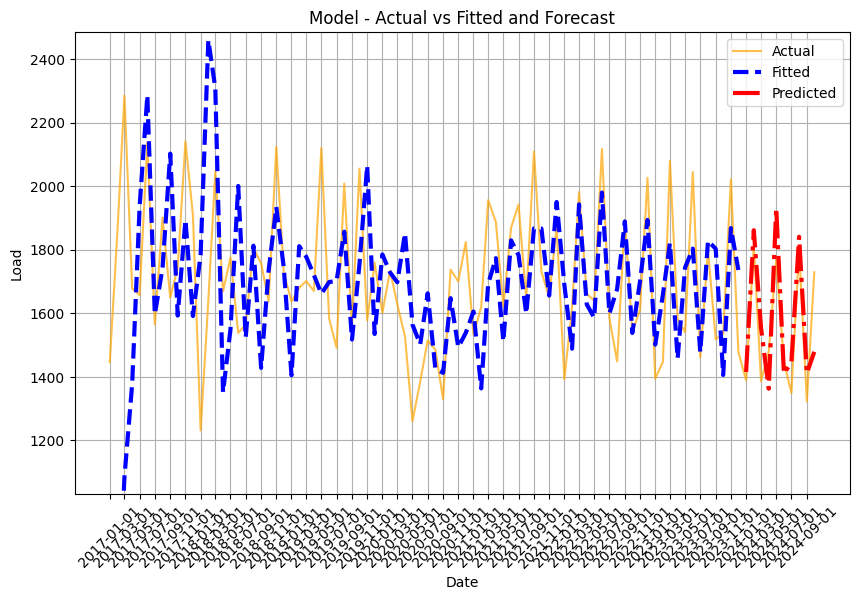

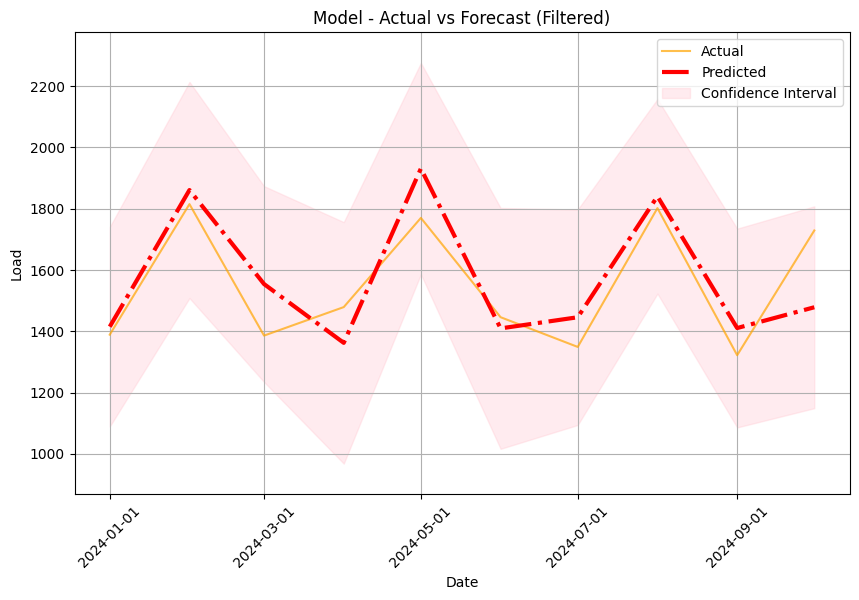

In [50]:
arima_prophet_functions.plot_model_results(final_data_check_metrics, main_column,
                   date_column='Date_Graph', 
                         prediction_column=f"{main_column}_Prediction", fitted_column=f"{main_column}_Fitted",
                         cutoff_date="12-30-2023",
                         ci_low_column=f"{main_column}_Prediction_CI_low", ci_upp_column=f"{main_column}_Prediction_CI_upp",
                                           vertical_line_date=None, 
                         vertical_line_ymin=None, vertical_line_ymax=None)

# Additional Things

Доп. вещи - тут это GARCH

## GARCH (1, 1)

In [51]:
from arch import arch_model

In [52]:
residuals = data_check_metrics['residuals'].dropna()

# Fit GARCH model on residuals
garch_model = arch_model(residuals, vol='Garch', p=1, q=1)

# Fitting
garch_results = garch_model.fit(disp='off')

# Print model summary
print(garch_results.summary())

                     Constant Mean - GARCH Model Results                      
Dep. Variable:              residuals   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -578.736
Distribution:                  Normal   AIC:                           1165.47
Method:            Maximum Likelihood   BIC:                           1175.20
                                        No. Observations:                   84
Date:                Thu, Jan 30 2025   Df Residuals:                       83
Time:                        20:07:47   Df Model:                            1
                               Mean Model                               
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu            10.0397     25.757      0.390      0.697 [-40.444, 60.52

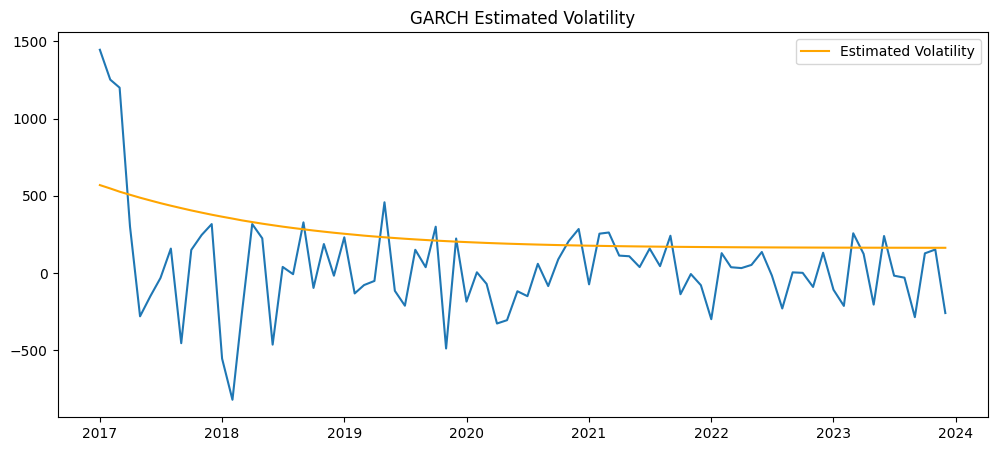

In [53]:
# Get the conditional volatility (sigma_t)
data_check_metrics['Volatility'] = garch_results.conditional_volatility

# Plot the volatility
plt.figure(figsize=(12, 5))
plt.plot(data_check_metrics['Date'], data_check_metrics['residuals'])
plt.plot(data_check_metrics['Date'], data_check_metrics['Volatility'], label="Estimated Volatility", color='orange')
plt.legend()
plt.title("GARCH Estimated Volatility")
plt.show()

In [54]:
# Forecast volatility for the next 12 periods (months, if monthly data)
forecast_horizon = 10
garch_forecast = garch_results.forecast(horizon=forecast_horizon)

# Extract forecasted conditional variance (square root to get standard deviation)
forecast_volatility = np.sqrt(garch_forecast.variance.values[:, :])

print("Forecasted Volatility for next periods:", forecast_volatility)

Forecasted Volatility for next periods: [[164.31716041 164.25875607 164.20511977 164.15586361 164.11063106
  164.06909441 164.03095249 163.99592854 163.96376828 163.93423804]]


In [55]:
garch_forecast.variance

,h.01,h.02,h.03,h.04,h.05,h.06,h.07,h.08,h.09,h.10
83,27000.129204,26980.938945,26963.321358,26947.147559,26932.299227,26918.66774,26906.153373,26894.664579,26884.117308,26874.434403


# Prophet Model Choosing

Этот модуль посвящен обучению лучшей Prophet модели. В отчёте будут сравниваться ARIMA vs. Prophet.

In [56]:
from prophet import Prophet

## Grid Search

In [72]:
# Подготовка данных
data_used_model = data_hosp_MR_used.copy()

# Train/Test split
data_model_train = data_used_model.loc[data_used_model.Date < pd.to_datetime("2024-01-01")].rename(columns={'Date': 'ds', main_column: 'y'})
data_model_test = data_used_model.loc[data_used_model.Date >= pd.to_datetime("2024-01-01")].rename(columns={'Date': 'ds', main_column: 'y'})

In [116]:
param_grid = {
    'weekly_seasonality': [False, True],
    'daily_seasonality': [False],
    'changepoint_prior_scale': [0.01, 0.05, 0.1],
    'n_changepoints': [10, 25, 50],
    'seasonality_mode': ['additive', 'multiplicative']
}

grid = list(itertools.product(*param_grid.values()))

In [117]:
param

(0.1, 50, 'multiplicative')

In [119]:
mape_lst = []

for param in grid:
    model = Prophet(growth='linear',
                    weekly_seasonality=param[0],
    yearly_seasonality=True,
    interval_width=0.8,
    changepoint_prior_scale=param[2],
                n_changepoints=param[3],
               seasonality_mode=param[4])

    model, data_check_metrics, forecast = arima_prophet_functions.prophet_model_train(model, data_model_train, data_model_test, main_column, plotting=False)
    metrics_df = arima_prophet_functions.calculate_model_metrics_prophet(data_check_metrics, main_column, verbose=False)

    dict_app = {"param": param, "mape_train":metrics_df['TRAIN'].loc['MAPE (%)'], "mape_test":metrics_df['TEST'].loc['MAPE (%)']}

    mape_lst.append(dict_app)

results_grid = pd.DataFrame(mape_lst)

20:18:35 - cmdstanpy - INFO - Chain [1] start processing
20:18:35 - cmdstanpy - INFO - Chain [1] done processing
20:18:35 - cmdstanpy - INFO - Chain [1] start processing
20:18:35 - cmdstanpy - INFO - Chain [1] done processing
20:18:35 - cmdstanpy - INFO - Chain [1] start processing
20:18:36 - cmdstanpy - INFO - Chain [1] done processing
20:18:36 - cmdstanpy - INFO - Chain [1] start processing
20:18:36 - cmdstanpy - INFO - Chain [1] done processing
20:18:36 - cmdstanpy - INFO - Chain [1] start processing
20:18:36 - cmdstanpy - INFO - Chain [1] done processing
20:18:36 - cmdstanpy - INFO - Chain [1] start processing
20:18:36 - cmdstanpy - INFO - Chain [1] done processing
20:18:36 - cmdstanpy - INFO - Chain [1] start processing
20:18:36 - cmdstanpy - INFO - Chain [1] done processing
20:18:36 - cmdstanpy - INFO - Chain [1] start processing
20:18:37 - cmdstanpy - INFO - Chain [1] done processing
20:18:37 - cmdstanpy - INFO - Chain [1] start processing
20:18:37 - cmdstanpy - INFO - Chain [1]

In [120]:
results_grid['MAPE_Sum'] = results_grid['mape_train'] + results_grid['mape_test']

In [121]:
results_grid.sort_values('mape_test')

,param,mape_train,mape_test,MAPE_Sum
22,"(True, False, 0.01, 50, additive)",6.409770,9.631075,16.040845
24,"(True, False, 0.05, 10, additive)",6.406674,9.631567,16.038241
26,"(True, False, 0.05, 25, additive)",6.404090,9.637626,16.041717
28,"(True, False, 0.05, 50, additive)",6.405476,9.640152,16.045628
20,"(True, False, 0.01, 25, additive)",6.399683,9.673624,16.073307
18,"(True, False, 0.01, 10, additive)",6.402344,9.675990,16.078334
19,"(True, False, 0.01, 10, multiplicative)",6.420496,9.686437,16.106933
27,"(True, False, 0.05, 25, multiplicative)",6.416524,9.707162,16.123686
25,"(True, False, 0.05, 10, multiplicative)",6.394779,9.707837,16.102616
29,"(True, False, 0.05, 50, multiplicative)",6.392276,9.708214,16.100490


## Best Model

In [122]:
param = (True, False, 0.01, 5, "additive")
model = Prophet(growth='linear',
    yearly_seasonality=True,
    weekly_seasonality=param[0],
    daily_seasonality=param[1],
    interval_width=0.8,
    changepoint_prior_scale=param[2],
                n_changepoints=param[3],
               seasonality_mode=param[4])

In [123]:
# Подготовка данных
data_used_model = data_hosp_MR_used.copy()

# Train/Test split
data_model_train = data_used_model.loc[data_used_model.Date < pd.to_datetime("2024-01-01")].rename(columns={'Date': 'ds', main_column: 'y'})
data_model_test = data_used_model.loc[data_used_model.Date >= pd.to_datetime("2024-01-01")].rename(columns={'Date': 'ds', main_column: 'y'})

20:19:02 - cmdstanpy - INFO - Chain [1] start processing
20:19:02 - cmdstanpy - INFO - Chain [1] done processing


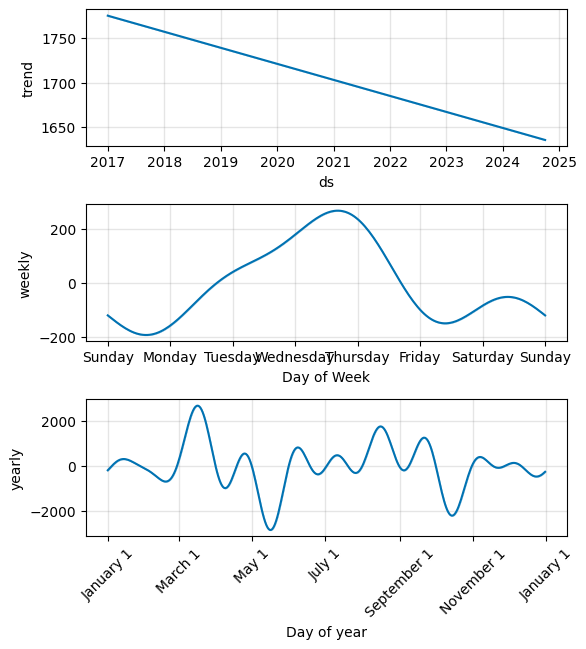

*** TRAIN ***
MAE: 106.19
MSE: 17982.64
RMSE: 134.10
MAPE: 6.41%
AIC: 1161.3433085054512

*** TEST ***
MAE: 137.55
MSE: 47466.79
RMSE: 217.87
MAPE: 9.64%


Ljung-Box Test
      lb_stat  lb_pvalue
10  36.991259   0.000057


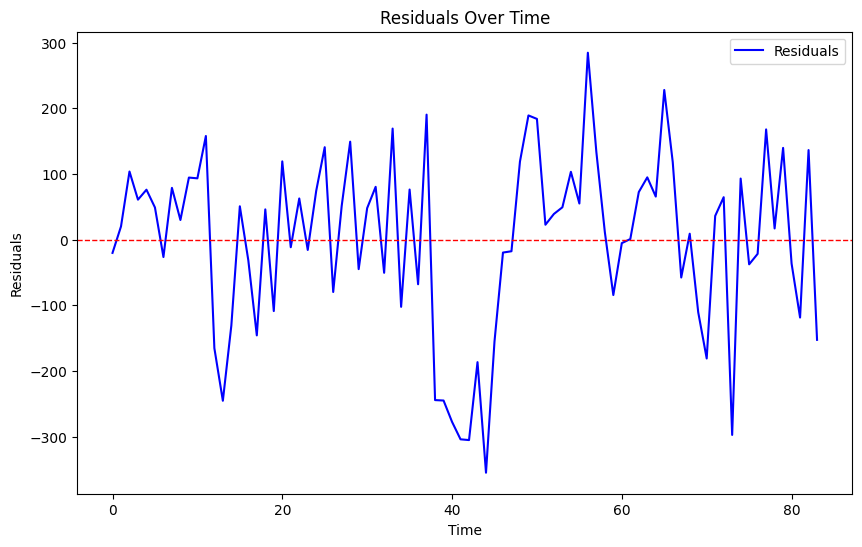

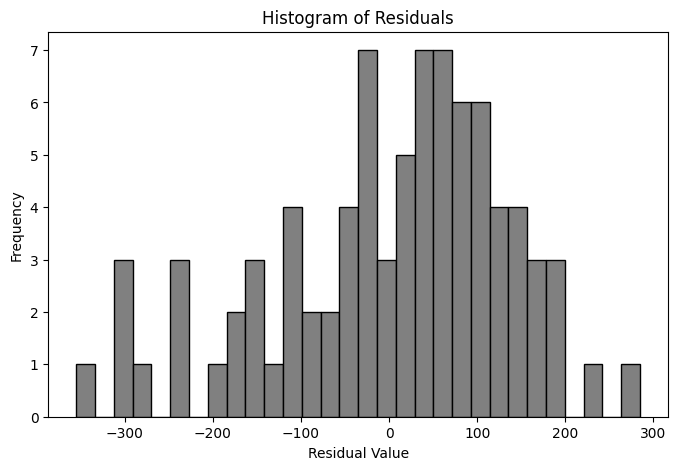

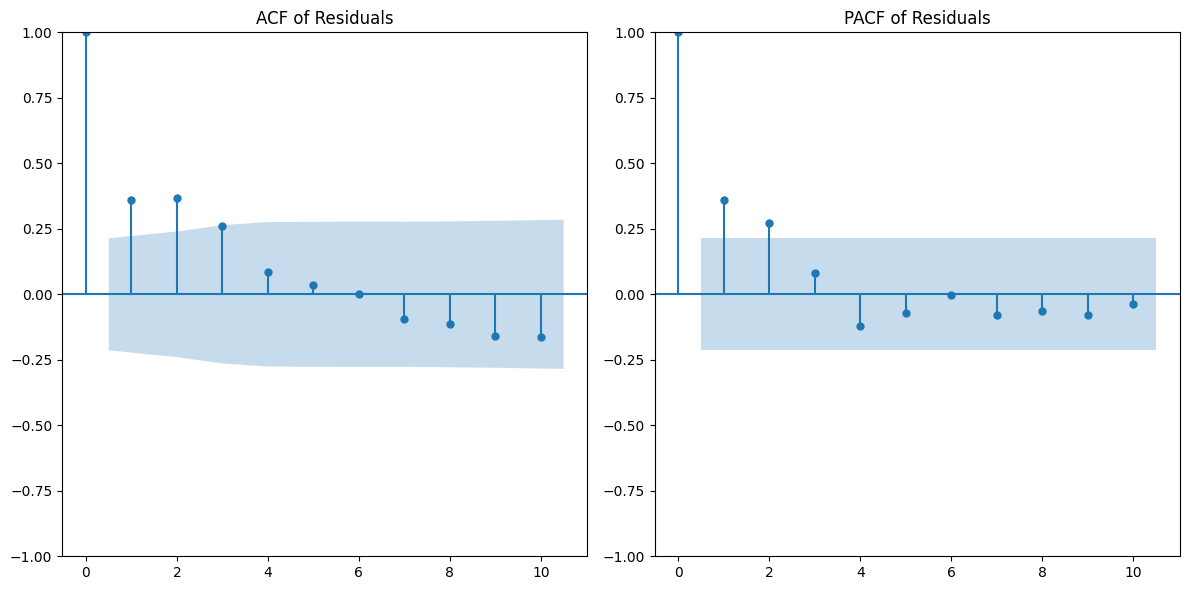

In [124]:
model, data_check_metrics, forecast = arima_prophet_functions.prophet_model_train(model, data_model_train, data_model_test, main_column=main_column)
metrics_df = arima_prophet_functions.calculate_model_metrics_prophet(data_check_metrics, main_column)
arima_prophet_functions.calcualate_model_performance_prophet(model, data_check_metrics, main_column)

In [125]:
metrics_df

Dataset,TRAIN,TEST
MAE,106.189195,137.548294
MSE,17982.643480,47466.789318
RMSE,134.099379,217.868743
MAPE (%),6.407666,9.640866
AIC,1161.343309,NaN


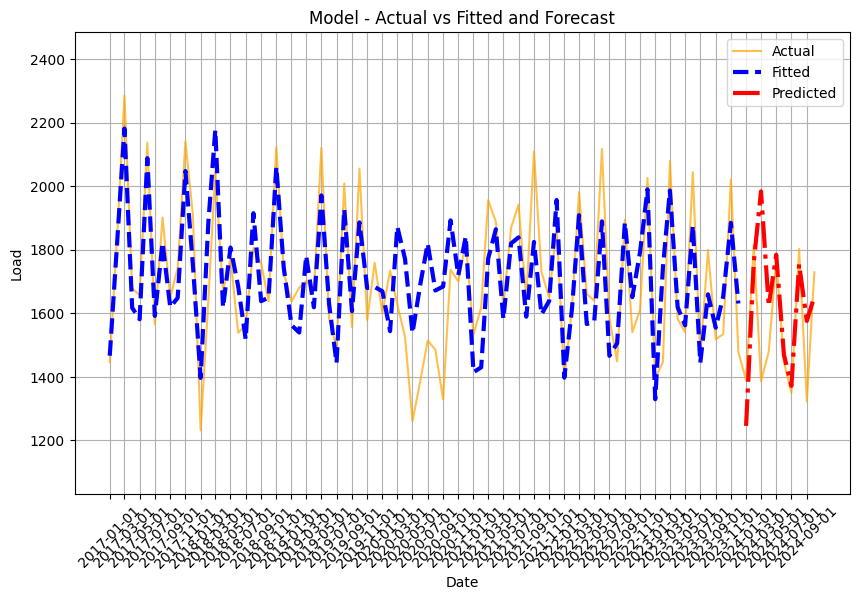

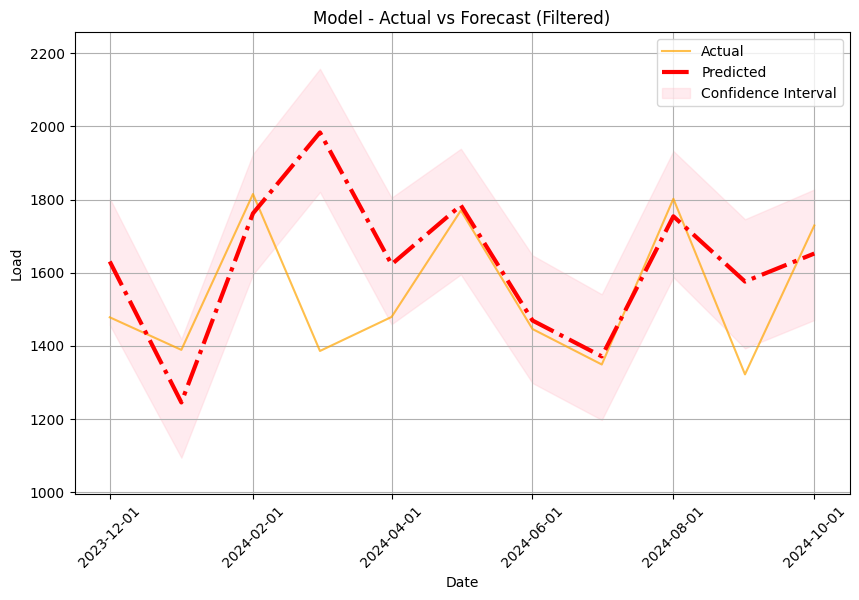

In [126]:
arima_prophet_functions.plot_model_results_prophet(data_check_metrics, main_column,
                   date_column='Date_Graph', 
                         prediction_column=f"{main_column}_Prediction", fitted_column=f"{main_column}_Fitted",
                           ci_low_column=f"{main_column}_Prediction_CI_low", ci_upp_column=f"{main_column}_Prediction_CI_upp", 
                         cutoff_date="12-30-2023", vertical_line_date=None, 
                         vertical_line_ymin=None, vertical_line_ymax=None)